### Computing BEB cross sections from the NIST orbital (norb) files
This notebook will demonstrate how to use the included `.norb` files to compute ionization cross sections for a list of molecules.
The required packages for the notebook are:

The user can modify the following variables:
- `alecs_db`: Path of the database root folder
- `molList`: List of molecules of interest to compute. Only the first 10 will be plotted
- `Nene`: Energy resolution of the cross sections
- `eArr`: Log-spaced array for the electron-impact energy, modify bounds as needed. Default is 10 eV - 1 MeV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
import copy

a0 = 5.29177211E-9 #cm
memp = 5.44617E-4
mpme = 1836.
atom_list = ['H', 'He', 'C', 'N', 'O', 'P', 'S', 'Ar']
alecs_db = "/Users/brandt/Data/ALeCS/"

molList = ['N2', 'NH3', 'CO2', 'H2O', 'PN', 'C2H2', 'CO', 'C2H4', 'NH2CHO', 'c-C6H6']
Nene = 256
eArr = np.logspace(1, 6, Nene)

This just loads in a convinent dictionary for all the molecules and their TeX formatting

In [2]:
molLatex = {}
f = open("molLatex.txt", 'r')
for l in f.readlines():
    s = l.split()
    molLatex[s[0]] = s[1]
f.close()

Function to compute the BEB cross section from the NITS data

In [3]:
def BEBCross(eArr, B, U, N):
    Nlev = len(B)
    Ryd = 13.605
    BEB = np.zeros(len(eArr))
    for i in range(Nlev):
        t = eArr/B[i]
        u = U[i]/B[i]
        Si = 4*np.pi*N[i]*(Ryd/B[i])**2
        fac1 = (Si/(t + (u + 1.)))
        fac2 = (np.log(t)/2.) * (1. - (1./(t**2)))
        fac3 = (1. - (1./t) - (np.log(t)/(t + 1.)))
        sigi = fac1*(fac2 + fac3)
        sigi[np.where(t < 1)] = 0.0
        BEB += sigi
    return BEB

Load in the NIST data, here using the MP2 data

In [4]:
BEBData = {}
BEBData['E'] = copy.copy(eArr)

for mol in molList:
    BEBdat = np.loadtxt(alecs_db+"NIST_orbitals/mp2/%s.norb"%mol, usecols=[1,2,3], comments="#")
    if BEBdat.ndim == 1:
        BEBData[mol] = BEBCross(eArr, [BEBdat[0]], [BEBdat[1]], [BEBdat[2]])
    else:
        BEBData[mol] = BEBCross(eArr, BEBdat[:,0], BEBdat[:,1], BEBdat[:,2])

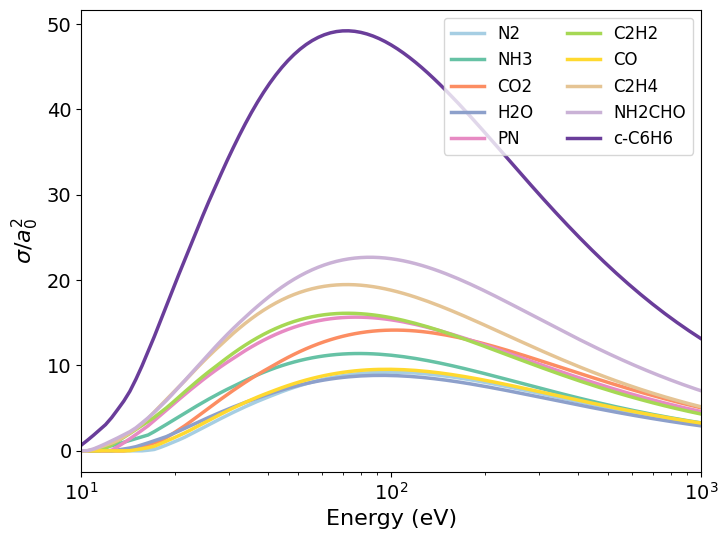

In [5]:
if len(molList) <= 10:
    plotMolList = copy.copy(molList)
else:
    plotMolList = molList[:10]
colors = ['#a6cee3', '#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#cab2d6', '#6a3d9a']
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
i = 0
for mi in molList: 
    ax.plot(BEBData['E'], BEBData[mi], '-', lw=2.5, color=colors[i], label=mi)
    i += 1
ax.legend(fontsize=12, loc=1, ncols=2)

ax.set_xscale('log')
ax.set_xlim(10, 1000)
ax.set_xlabel("Energy (eV)", fontsize=16)
ax.set_ylabel(r"$\sigma/a_0^2$", fontsize=16)
ax.tick_params(which='both', axis='both', labelsize=14)
plt.show()

Output in the ALeCS format the cross sections

In [6]:
for mol in molList:
    with open("%s.xs"%mol, 'w+') as f:
        f.write("# %s cross section\n"%mol)
        f.write("%d\n"%Nene)
        for (ei, xsi) in zip(BEBData['E'], BEBData[mol]):
            f.write("%.5e\t%.5e\n"%(ei,xsi))